In [79]:
""" imports """
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.model_selection import train_test_split

In [80]:
""" load data """
flowers : list[str] = []

def assignFlower(raw : bytes) -> int:
    """ converts bytes data to a string, then assigns each flower type an int """
    global flowers
    flower : str = raw.decode("utf-8")
    flowers += [flower] if flower not in flowers else []
    return flowers.index(flower)

data = np.loadtxt(open("iris.data", "rb"), delimiter=",", converters={4 : assignFlower})
X = data[:,:4]
y = data[:,4]

k = len(flowers)
X.shape

(150, 4)

In [81]:
""" provides the top 2 PCs """

def topPCs(dataset : np.ndarray) -> tuple[np.ndarray]:
    d = (dataset-dataset.mean())/dataset.std()
    u, s, vh = np.linalg.svd(d, full_matrices=True)
    return vh[:2]  # return

def svd(dataset : np.ndarray) -> np.ndarray:
    d = (dataset-dataset.mean())/dataset.std()
    u, ls, vh = np.linalg.svd(d, full_matrices=True)

    s = np.zeros((u.shape[0],2))
    np.fill_diagonal(s, ls)

    dataset_svd = np.dot(u, s)

    return dataset_svd

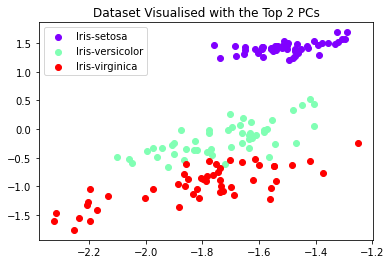

In [82]:
""" display data as 2D plot """
Z : np.ndarray = svd(X)

for i, colour in zip(range(k), cm.rainbow(np.linspace(0,1, k))):
    flowerIndexes = [int(j) for j, f in enumerate(y) if f==i]
    Zp = np.array([Z[j] for j in flowerIndexes]) 
    plt.scatter(Zp[:,0], Zp[:,1], color=colour, label=f"{flowers[i]}")

plt.title("Dataset Visualised with the Top 2 PCs")
plt.legend(loc="upper left")
plt.show()